# Parameter Exploration

In [1]:
import brainstate
import braintools
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

import brainmass
from datasets import Dataset

In [2]:
brainstate.environ.set(dt=0.1)

hcp = Dataset('hcp')

target_fc = jax.tree.map(lambda x: braintools.metric.functional_connectivity(x.T), hcp.BOLDs)
target_fc = jnp.mean(jnp.asarray(target_fc), axis=0)

Loading dataset hcp from D:\codes\projects\brainmass\examples\datasets\hcp.
Dataset hcp loaded.


In [3]:
class Network(brainstate.nn.Module):
    def __init__(self, signal_speed=2., k=1., sigma=0.01):
        super().__init__()

        conn_weight = hcp.Cmat
        np.fill_diagonal(conn_weight, 0)
        delay_time = hcp.Dmat / signal_speed
        np.fill_diagonal(delay_time, 0)
        indices_ = np.tile(np.arange(conn_weight.shape[1]), conn_weight.shape[0])

        self.node = brainmass.WilsonCowanModel(
            80,
            noise_E=brainmass.OUProcess(80, sigma=sigma),
            noise_I=brainmass.OUProcess(80, sigma=sigma),
        )
        self.coupling = brainmass.DiffusiveCoupling(
            self.node.prefetch_delay('rE', (delay_time.flatten(), indices_), init=brainstate.init.Uniform(0, 0.05)),
            self.node.prefetch('rE'),
            conn_weight,
            k=k
        )

    def update(self):
        current = self.coupling()
        rE = self.node(current)
        return rE

    def step_run(self, i):
        with brainstate.environ.context(i=i, t=i * brainstate.environ.get_dt()):
            return self.update()

In [4]:
def simulation(k, sigma):
    net = Network(k=k, sigma=sigma)
    brainstate.nn.init_all_states(net)
    indices = np.arange(0, 6e3 // brainstate.environ.get_dt())
    exes = brainstate.transform.for_loop(net.step_run, indices)
    fc = braintools.metric.functional_connectivity(exes)
    return braintools.metric.matrix_correlation(target_fc, fc)

## Grid Search

In [5]:
all_ks = jnp.linspace(0.5, 3.0, 10)
all_sigmas = jnp.linspace(0.01, 0.2, 10)

In [6]:
@brainstate.transform.jit
def parameter_exploration(ks, sigmas):
    results = brainstate.transform.vmap(
        lambda k: brainstate.transform.vmap(lambda sigma: simulation(k, sigma))(sigmas)
    )(ks)
    return results

In [7]:
correlations = parameter_exploration(all_ks, all_sigmas)

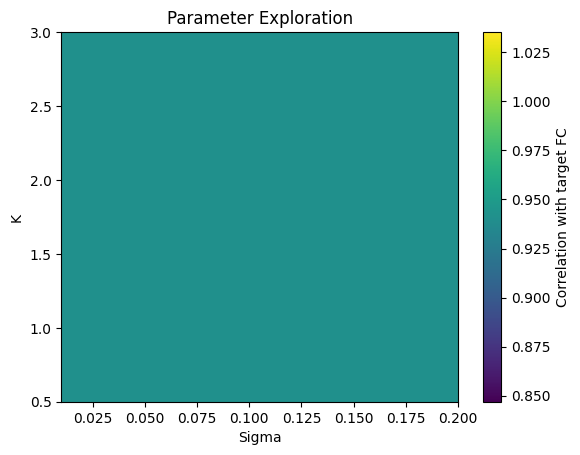

In [8]:
plt.imshow(correlations, extent=(all_sigmas[0], all_sigmas[-1], all_ks[0], all_ks[-1]), origin='lower', aspect='auto')
plt.colorbar(label='Correlation with target FC')
plt.xlabel('Sigma')
plt.ylabel('K')
plt.title('Parameter Exploration')
plt.show()

## Parameter Optimization with Nevergrad

[nevergrad](https://github.com/facebookresearch/nevergrad) is a Python toolbox for performing gradient-free optimization.

In [7]:
@brainstate.transform.jit
def vmap_loss_fn(k):
    return 1 - brainstate.transform.vmap(lambda x: simulation(x, sigma=0.05))(k)

In [ ]:
opt = braintools.optim.NevergradOptimizer(
    vmap_loss_fn, method='DE', n_sample=20, bounds={'k': [0.5, 3.0]}
)
opt.initialize()
opt.minimize(n_iter=10)

Iteration 0, best error: 0.73056, best parameters: {'k': 2.956561953800605}
